In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# importing the dataset using dask

%time data = pd.read_csv('drive/My Drive/online_fraud.csv')

print(data.shape)

CPU times: user 18.9 ms, sys: 6.27 ms, total: 25.2 ms
Wall time: 448 ms
(3580, 11)


In [3]:
data.info()
data.describe()
#checking how many frauds are there

data['isFraud'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3580 entries, 0 to 3579
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            3580 non-null   int64  
 1   type            3580 non-null   object 
 2   amount          3580 non-null   float64
 3   nameOrig        3580 non-null   object 
 4   oldbalanceOrg   3580 non-null   float64
 5   newbalanceOrig  3580 non-null   float64
 6   nameDest        3580 non-null   object 
 7   oldbalanceDest  3580 non-null   float64
 8   newbalanceDest  3580 non-null   float64
 9   isFraud         3580 non-null   int64  
 10  isFlaggedFraud  3580 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 307.8+ KB


0    3558
1      22
Name: isFraud, dtype: int64

In [4]:
data['type'].value_counts()

PAYMENT     1872
CASH_IN      657
CASH_OUT     487
TRANSFER     355
DEBIT        209
Name: type, dtype: int64

In [5]:
# finding  out the types of fraudulent transaction types out of all the transaction modes.

print('The Types of fraudulent transactions are {}'.format(list(data.loc[data.isFraud == 1].type.drop_duplicates().values)) )


The Types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']


In [6]:
# making dependent and independent sets

X = data.loc[(data.type == 'TRANSFER') | (data.type == 'CASH_OUT')]
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [7]:
# feature engg.

X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

<ipython-input-7-f0384320cda1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
<ipython-input-7-f0384320cda1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest


In [8]:
# removing unwanted columns

X = X.drop(['nameDest','nameOrig'], axis = 1)

# checking the new shape of data
X.shape

(842, 11)

In [9]:
# label encoding for the transaction type

X['type'].replace('TRANSFER', 0, inplace = True)
X['type'].replace('CASH_OUT', 1, inplace = True)

In [10]:
# looking at the head of the data
X.head(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,1,0,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,1,0,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0,0,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,300850.89,-2401220.0


In [11]:
X.isnull().any().any()

False

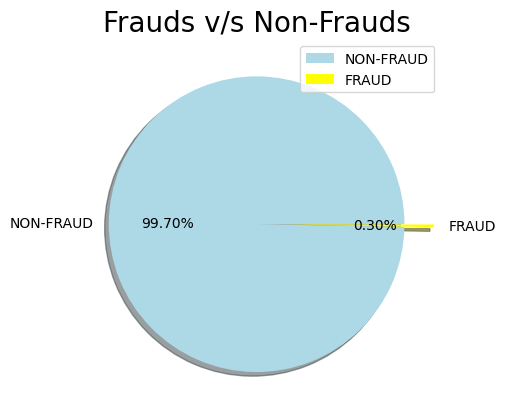

In [12]:


# plotting a pie chart to represent the fraction of the frauds

size = [2762196, 8213]
labels = ['NON-FRAUD', 'FRAUD']
colors = ['lightblue', 'yellow']
explode = [0, 0.2]

plt.pie(size, labels = labels, colors = colors, explode = explode, shadow  = True, autopct = '%.2f%%')
plt.title('Frauds v/s Non-Frauds', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

In [13]:
X['isFraud'].value_counts()
# making our independent set

Y = X['isFraud']

# removing the dependent set
X = X.drop(['isFraud'], axis = 1)
# getting the shapes of x and y
print("Shape of x: ", X.shape)
print("Shape of y: ", Y.shape)

Shape of x:  (842, 10)
Shape of y:  (842,)


In [14]:
# splitting the dataset into train and tests

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)

# checking the new shapes
print("Shape of x_train: ", x_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)
# performing standard scaling on the data for better fit

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Shape of x_train:  (673, 10)
Shape of x_test:  (169, 10)
Shape of y_train:  (673,)
Shape of y_test:  (169,)


In [15]:
# Using XGBOOST


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import average_precision_score

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# score of the model
auprc = average_precision_score(y_test, y_pred)
print("The Area under Precision Recall Curve Score is", auprc)
# looking at the confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

The Area under Precision Recall Curve Score is 1.0
[[166   0]
 [  0   3]]
